In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
import statistics
#from function import *
import statsmodels.api as sm
from datetime import datetime, timedelta
import time
from btbase import *

In [3]:
# test class
# 可以模拟真实市场来判断阶数的选择
class test:
    
    # 初始化
    # dataframe: 本地dataframe
    # data_laundry: 所有在t时间用到的数据（包括error项） 以及真实的volatility和预测的volatility
    # start_time: 数据开始时间
    # end_time: 数据结束时间
    # data_record: 在t时间用到的数据（不包括error项）不包括真实的volatility和预测的volatility （缩短拟合时间）
    def __init__(self):
        self.dataframe = None
        self.data_laundry = None
        self.start_time = None
        self.end_time = None
        self.data_record = None
    
    # 通过平台api获取数据
    def set_data(self, s_time, e_time, symbols='btc/usdt.spot.binance', fields=None, bar_type="1m", offset=None, engine_info=None):
        # 获取数据api
        self.dataframe = get_crypto_price(s_time, e_time, symbols=symbol_, fields=None, bar_type="1m", offset=None, engine_info=None)
        # 把收益率加入到dataframe中
        self.dataframe = self.dataframe.assign(return_close= self.dataframe['close'].pct_change() * 100)
        # 获取数据的开始时间
        self.start_time = self.dataframe['e_date'].iloc[0]
        # 获取数据的结束时间
        self.end_time = self.dataframe['e_date'].iloc[-1]
    
    # 通过dataframe文件获取数据
    def set_data_df(self, dataframe):
        # 本地dataframe
        self.dataframe = dataframe  
        # 把收益率加入到dataframe中 
        self.dataframe = self.dataframe.assign(return_close= self.dataframe['close'].pct_change() * 100) 
        # 获取数据的开始时间
        self.start_time = self.dataframe['e_date'].iloc[0] 
        # 获取数据的结束时间
        self.end_time = self.dataframe['e_date'].iloc[-1]
        
    
    # 方程用来得到相应步长的volatility
    # 结果是顺序的dataframe包含每个以小时为单位的区间volatility
    def get_volatility(self, time_step):
        # 倒序向前60分钟 作为每个区间的endtime
        time_range = pd.date_range(start=self.end_time , end=self.start_time, freq = timedelta(minutes = -60))
        # 建立dataframe
        hour_table = pd.DataFrame({'hour_e_time': time_range})
        # 根据time_step确定每个区间长度
        hour_table.insert(0, 'hour_s_time' , time_range + timedelta(minutes = - time_step))
        volatility = []
        # 在dataframe中取出相应区间的收益率并计算标准差得到volatility
        for i in hour_table.index:
            volatility.append(np.std(self.dataframe['return_close'][(self.dataframe.e_date > hour_table.hour_s_time[i]) & (self.dataframe.e_date <=  hour_table.hour_e_time[i])].dropna()))
        # 加入dataframe
        hour_table['volatility'] = volatility
        # 换成顺序排列
        return hour_table.dropna()[::-1].reset_index(drop=True)
    
    # 相应步长内最高和最低值的差值
    # 结果是顺序的dataframe包含每个以小时为单位的区间high和low的差值
    def get_maximum_highlow_difference(self, time_step):
        # 倒序向前60分钟 作为每个区间的endtime
        time_range = pd.date_range(start=self.end_time , end=self.start_time, freq = timedelta(minutes = -60))
        hour_table = pd.DataFrame({'hour_e_time': time_range})
        # 根据time_step确定每个区间长度
        # 这样就可以得到每个区间的starttime 区间长度为time_step
        hour_table.insert(0, 'hour_s_time' , time_range + timedelta(minutes = - time_step))

        difference = []
        # 在dataframe中取出相应区间的最高和最低值做差
        for i in hour_table.index:
            # 根据hour_table的starttime和endtime取出相应的dataframe
            df_curr = self.dataframe[(self.dataframe.e_date > hour_table.hour_s_time[i]) & (self.dataframe.e_date <=  hour_table.hour_e_time[i])]
            # 取出最高和最低值
            high = max(df_curr['high'].dropna())
            low = min(df_curr['low'].dropna())
            difference.append(high - low)
        # 加入dataframe
        hour_table['highlow_difference'] = difference
        # 换成顺序排列
        return hour_table.dropna()[::-1].reset_index(drop=True)      
    
    
    # 相应步长内每分钟high和low的差值的标准差
    # 结果是顺序的dataframe包含每个以小时为单位的区间high和low的差值的sum
    def get_highlow(self, time_step):
        # 倒序向前60分钟 作为每个区间的endtime
        time_range = pd.date_range(start=self.end_time , end=self.start_time, freq = timedelta(minutes = -60))
        hour_table = pd.DataFrame({'hour_e_time': time_range})
        # 根据time_step确定每个区间长度
        # 这样就可以得到每个区间的starttime 区间长度为time_step
        hour_table.insert(0, 'hour_s_time' , time_range + timedelta(minutes = - time_step))

        highlow = []
        # 在dataframe中取出相应区间的high和low的差值并计算sim得到
        for i in hour_table.index:
            # 根据hour_table的starttime和endtime取出相应的dataframe
            df_curr = self.dataframe[(self.dataframe.e_date > hour_table.hour_s_time[i]) & (self.dataframe.e_date <=  hour_table.hour_e_time[i])]
            highlow.append(np.sum(df_curr['high'] - df_curr['low']))

        # 加入dataframe
        hour_table['highlow'] = highlow
        # 换成顺序排列
        return hour_table.dropna()[::-1].reset_index(drop=True)  
    
    # 计算每个区间volume_sum
    # 结果是顺序的dataframe包含每个以小时为单位的区间volume_sum
    def get_volume_sum(self, time_step):
        # 倒序向前60分钟 作为每个区间的endtime
        time_range = pd.date_range(start=self.end_time , end=self.start_time, freq = timedelta(minutes = -60))
        hour_table = pd.DataFrame({'hour_e_time': time_range})
        # 根据time_step确定每个区间长度
        # 这样就可以得到每个区间的starttime 区间长度
        hour_table.insert(0, 'hour_s_time' , time_range + timedelta(minutes = - time_step))

        volume_sum = []
        # 在dataframe中取出相应区间的high和low的差值并计算标准差得到
        for i in hour_table.index:
            # 根据hour_table的starttime和endtime取出相应的dataframe
            df_curr = self.dataframe[(self.dataframe.e_date > hour_table.hour_s_time[i]) & (self.dataframe.e_date <=  hour_table.hour_e_time[i])]
            volume_sum.append(np.sum(df_curr['volume']))
        
        # 加入dataframe
        hour_table['volume_sum'] = volume_sum
        # 换成顺序排列
        return hour_table.dropna()[::-1].reset_index(drop=True)  

    # 计算每个区间头尾的收益率的平方(Rt^2)
    # Rt = (Pt - Pt-1)/Pt-1
    # 这里t以timestep为单位
    def get_return_square(self, time_step):
        # 倒序向前60分钟 作为每个区间的endtime
        time_range = pd.date_range(start=self.end_time , end=self.start_time, freq = timedelta(minutes = -60))
        hour_table = pd.DataFrame({'hour_e_time': time_range})
        # 根据time_step确定每个区间长度
        hour_table.insert(0, 'hour_s_time' , time_range + timedelta(minutes = - time_step))
        
        return_square = []
        # 在dataframe中取出相应区间的high和low的差值并计算标准差得到
        for i in hour_table.index:
            # 根据hour_table的starttime和endtime取出相应的dataframe
            close = self.dataframe['close'][(self.dataframe.e_date > hour_table.hour_s_time[i]) & (self.dataframe.e_date <=  hour_table.hour_e_time[i])].dropna()
            # Rt^2 = ((Pt - Pt-1)/Pt-1)^2
            return_square.append(((close.values[0] - close.values[-1] )/ close.values[0])**2)
            #return_square.append((np.log(close.values[0]/close.values[-1]))**2)

        # 加入dataframe
        hour_table['return_square'] = return_square
        # 换成顺序排列
        return hour_table.dropna()[::-1].reset_index(drop=True)
    
    # 计算每个区间volume_sum的zscore
    # zscore = (x - mean(x))/std(x)
    # 这里mean(x)是每个period内的volume_sum的均值 period用小时作为单位
    # std(x)是每个period内的volume_sum的标准差
    # x是每个time_step内的volume_sum
    def get_zscore(self, time_step, period):
        # 得到每个time_step的volume_sum
        original = self.get_volume_sum(time_step)
        zscore = []
        
        # 倒序向前60分钟 作为每个区间的endtime
        time_range = pd.date_range(start=self.end_time , end=self.start_time, freq = timedelta(minutes = -60))
        hour_table = pd.DataFrame({'hour_e_time': time_range})
        # 根据period确定每个mean和std范围
        hour_table.insert(0, 'hour_s_period' , time_range + timedelta(hours = - period))  
        
        # 删除最后一个区间
        # 因为最后一个区间的数据是不完整的
        hour_table = hour_table.iloc[:-period]
        
        # 计算zscore
        for i in hour_table.index:
            # 取出相应区间的volume_sum
            df_curr = original[(original.hour_e_time > hour_table.hour_s_period[i]) & (original.hour_e_time <=  hour_table.hour_e_time[i])]
            zscore.append((df_curr['volume_sum'].iloc[-1] - np.mean(df_curr['volume_sum']))/np.std(df_curr['volume_sum']))
        
        # 加入dataframe
        hour_table['zscore'] = zscore
        
        # 换成顺序排列
        return hour_table.dropna()[::-1].reset_index(drop=True)    

    # 得到模型
    # 如果有moving average 则返回两个模型
    # order: 每个变量的阶数
    # order[0]: highlow_difference
    # order[1]: highlow
    # order[2]: volume_sum
    # order[3]: return_square
    # order[4]: volatility
    # order[5]: zscore
    # timestep: 每个变量的时间步长 这里timestep[5]是一个list 第一个是zscore的时间步长 第二个是zscore的period
    # ma: moving average的阶数
    # 模型是volatility = a0 + b(n)*highlow_difference(t-n) + c(n)*highlow(t-n) + d(n)*volume_sum(t-n) + e(n)*return_square(t-n) + f(n)*volatility(t-n) + g(n)*zscore(t-n) + h(n)*error(t-n) + error
    def HLVGARCH_MA(self, order = [1, 1, 1, 1, 1, 1], timestep = [60, 60, 60, 60, 60, [60, 24]], ma = 0):
        # 倒序向前60分钟 作为每个区间的endtime
        # 区间长度是60分钟
        time_range = pd.date_range(start=self.end_time , end=self.start_time, freq = timedelta(minutes = -60))
        self.data_laundry = pd.DataFrame({'hour_e_time': time_range})
        self.data_laundry.insert(0, 'hour_s_time' , time_range + timedelta(minutes = - 60))

        # 换成顺序排列
        self.data_laundry = self.data_laundry.dropna()[::-1].reset_index(drop=True)
        
        # 得到volatility
        dataframe_volatility_real = self.get_volatility(60).drop(columns = ['hour_s_time'])
        
        # 把真实的volatility加入到dataframe中
        self.data_laundry = self.data_laundry.merge(dataframe_volatility_real, on = 'hour_e_time', how = 'inner')
        
        # highlow_difference（t-n） n为order[0]的阶数
        if order[0] >0:
            # 得到每个时段的highlow_difference
            dataframe_highlow_diff = self.get_maximum_highlow_difference(timestep[0]).drop(columns = ['hour_s_time'])
            for i in range(order[0]):
                # shift i+1 个单位
                # 以此得到t-1, t-2, t-3。。。的highlow_difference
                dataframe_highlow_diff['highlow_difference_t' + str(i)] = dataframe_highlow_diff['highlow_difference'].shift(i+1)  
            # 根据endtime合并 dataframe    
            self.data_laundry = self.data_laundry.merge(dataframe_highlow_diff.drop(columns = ['highlow_difference']), on = 'hour_e_time', how = 'inner')
        
        # highlow（t-n） n为order[1]的阶数
        if order[1] >0:
            # 得到每个时段的highlow
            dataframe_highlow = self.get_highlow(timestep[1]).drop(columns = ['hour_s_time'])
            for i in range(order[1]):
                # shift i+1 个单位
                # 以此得到t-1, t-2, t-3。。。的highlow
                dataframe_highlow['highlow_t' + str(i)] = dataframe_highlow['highlow'].shift(i+1)
            # 根据endtime合并 dataframe    
            self.data_laundry = self.data_laundry.merge(dataframe_highlow.drop(columns = ['highlow']), on = 'hour_e_time', how = 'inner')
        
        # volume_sum（t-n） n为order[2]的阶数
        if order[2] >0:
            # 得到每个时段的volume_sum
            dataframe_volume_sum = self.get_volume_sum(timestep[2]).drop(columns = ['hour_s_time'])
            for i in range(order[2]):
                # shift i+1 个单位
                # 以此得到t-1, t-2, t-3。。。的volume_sum
                dataframe_volume_sum['volume_sum_t' + str(i)] = dataframe_volume_sum['volume_sum'].shift(i+1)
            # 根据endtime合并 dataframe    
            self.data_laundry = self.data_laundry.merge(dataframe_volume_sum.drop(columns = ['volume_sum']), on = 'hour_e_time', how = 'inner')

        if order[3] >0:
            # 得到每个时段的return_square
            dataframe_return_square = self.get_return_square(timestep[3]).drop(columns = ['hour_s_time'])
            for i in range(order[3]):
                # shift i+1 个单位
                # 以此得到t-1, t-2, t-3。。。的return_square
                dataframe_return_square['return_square_t' + str(i)] = dataframe_return_square['return_square'].shift(i+1)
            # 根据endtime合并 dataframe    
            self.data_laundry = self.data_laundry.merge(dataframe_return_square.drop(columns = ['return_square']), on = 'hour_e_time', how = 'inner')
        
        if order[4] >0:
            # 得到每个时段的volatility
            dataframe_volatility = self.get_volatility(timestep[4]).drop(columns = ['hour_s_time'])
            for i in range(order[4]):
                # shift i+1 个单位
                # 以此得到t-1, t-2, t-3。。。的volatility
                dataframe_volatility['volatility_t' + str(i)] = dataframe_volatility['volatility'].shift(i+1)
            # 根据endtime合并 dataframe    
            self.data_laundry = self.data_laundry.merge(dataframe_volatility.drop(columns = ['volatility']), on = 'hour_e_time', how = 'inner')
        
        if order[5] >0:
            # 得到每个时段的volatility
            dataframe_volatility = self.get_volatility(timestep[5]).drop(columns = ['hour_s_time'])
            for i in range(order[5]):
                # shift i+1 个单位
                # 以此得到t-1, t-2, t-3。。。的volatility
                dataframe_volatility['volatility2_t' + str(i)] = dataframe_volatility['volatility'].shift(i+1)
            # 根据endtime合并 dataframe    
            self.data_laundry = self.data_laundry.merge(dataframe_volatility.drop(columns = ['volatility']), on = 'hour_e_time', how = 'inner')   
        
        # 删除缺失值 对其数据
        self.data_laundry = self.data_laundry.dropna()
       
        # 真实的volatility 用来拟合
        Y = self.data_laundry['volatility']
        # 除了volatility的其他数据 用来作为自变量
        X = self.data_laundry.drop(columns = ['hour_e_time', 'hour_s_time', 'volatility'])
        
        # 拟合模型 加上截距
        model = [sm.OLS(Y, sm.add_constant(X)).fit()]
        
        # 把预测volatility加入到dataframe中
        self.data_laundry['predict_volatility'] = model[0].predict(sm.add_constant(X))
        
        # 加入真实volatility
        self.data_laundry['volatility'] = self.data_laundry['volatility']
        
        # 如果有moving average
        if ma > 0:
            # 计算误差
            self.data_laundry['error'] = self.data_laundry['volatility'] - self.data_laundry['predict_volatility']
            # 得到t-1, t-2, t-3。。。的误差
            for i in range(ma):
                self.data_laundry['error_t' + str(i)] = self.data_laundry['error'].shift(i+1)
            
            # 删除缺失值
            self.data_laundry = self.data_laundry.dropna()
            # 真实的volatility 用来拟合
            Y = self.data_laundry['volatility']
            # 除了volatility的其他数据 用来作为自变量
            X = self.data_laundry.drop(columns = ['hour_e_time', 'hour_s_time', 'volatility', 'predict_volatility', 'error'])
            # 拟合模型
            model.append(sm.OLS(Y, sm.add_constant(X)).fit()) 
            self.data_laundry = self.data_laundry.drop(columns = ['error'])   
        
        # 加入真实volatility和预测volatility
        self.data_laundry['real'] = self.data_laundry['volatility']
        self.data_laundry['predict'] = model[-1].predict(sm.add_constant(X))
        
        # 删除不需要的数据
        self.data_laundry = self.data_laundry.drop(columns = [ 'volatility', 'predict_volatility'])

        # 返回模型
        return model
    
    # data record主要是用来方便滚动预测提取数据 减少拟合时间
    # 输入order和timestep 就可以得到相应每个时段的数据
    # highlow_difference(t-n)  highlow(t-n)  volume_sum(t-n)  return_square(t-n)  volatility(t-n)  zscore(t-n)   t 
    def set_data_record(self, order, timestep):
        # 倒序向前60分钟 作为每个区间的endtime
        time_range = pd.date_range(start=self.end_time , end=self.start_time, freq = timedelta(minutes = -60))
        # 建立dataframe
        self.data_record = pd.DataFrame({'hour_e_time': time_range})
        # 根据time_step确定每个区间长度
        self.data_record.insert(0, 'hour_s_time' , time_range + timedelta(minutes = - 60))
        # 换成顺序排列
        self.data_record = self.data_record.dropna()[::-1].reset_index(drop=True)
        
        # 得到volatility
        dataframe_volatility_real = self.get_volatility(60).drop(columns = ['hour_s_time'])
        
        # 把真实的volatility加入到dataframe中
        self.data_record = self.data_record.merge(dataframe_volatility_real, on = 'hour_e_time', how = 'inner')

        if order[0] >0:
            # 得到每个时段的highlow_difference
            dataframe_highlow_diff = self.get_maximum_highlow_difference(timestep[0]).drop(columns = ['hour_s_time'])
            for i in range(order[0]):
                # shift i+1 个单位
                # 以此得到t-1, t-2, t-3。。。的highlow_difference
                dataframe_highlow_diff['highlow_difference_t' + str(i)] = dataframe_highlow_diff['highlow_difference'].shift(i+1)  
            # 根据endtime合并 dataframe    
            self.data_record = self.data_record.merge(dataframe_highlow_diff.drop(columns = ['highlow_difference']), on = 'hour_e_time', how = 'inner')
        
        if order[1] >0:
            # 得到每个时段的highlow
            dataframe_highlow = self.get_highlow(timestep[1]).drop(columns = ['hour_s_time'])
            for i in range(order[1]):
                # shift i+1 个单位
                # 以此得到t-1, t-2, t-3。。。的highlow
                dataframe_highlow['highlow_t' + str(i)] = dataframe_highlow['highlow'].shift(i+1)
            # 根据endtime
            self.data_record = self.data_record.merge(dataframe_highlow.drop(columns = ['highlow']), on = 'hour_e_time', how = 'inner')
        
        if order[2] >0:
            # 得到每个时段的volume_sum
            dataframe_volume_sum = self.get_volume_sum(timestep[2]).drop(columns = ['hour_s_time'])
            for i in range(order[2]):
                # shift i+1 个单位
                # 以此得到t-1, t-2, t-3。。。的volume_sum
                dataframe_volume_sum['volume_sum_t' + str(i)] = dataframe_volume_sum['volume_sum'].shift(i+1)
            # 根据endtime合并 dataframe    
            self.data_record = self.data_record.merge(dataframe_volume_sum.drop(columns = ['volume_sum']), on = 'hour_e_time', how = 'inner')
        
        if order[3] >0:
            # 得到每个时段的return_square
            dataframe_return_square = self.get_return_square(timestep[3]).drop(columns = ['hour_s_time'])
            for i in range(order[3]):
                # shift i+1 个单位
                # 以此得到t-1, t-2, t-3。。。的return_square
                dataframe_return_square['return_square_t' + str(i)] = dataframe_return_square['return_square'].shift(i+1)
            # 根据endtime合并 dataframe    
            self.data_record = self.data_record.merge(dataframe_return_square.drop(columns = ['return_square']), on = 'hour_e_time', how = 'inner')
        
        if order[4] >0:
            # 得到每个时段的volatility
            dataframe_volatility = self.get_volatility(timestep[4]).drop(columns = ['hour_s_time'])
            for i in range(order[4]):
                # shift i+1 个单位
                # 以此得到t-1, t-2, t-3。。。的volatility
                dataframe_volatility['volatility_t' + str(i)] = dataframe_volatility['volatility'].shift(i+1)
            # 根据endtime合并 dataframe    
            self.data_record = self.data_record.merge(dataframe_volatility.drop(columns = ['volatility']), on = 'hour_e_time', how = 'inner')
        
        if order[5] >0:
            # 得到每个时段的volatility
            dataframe_volatility = self.get_volatility(timestep[5]).drop(columns = ['hour_s_time'])
            for i in range(order[5]):
                # shift i+1 个单位
                # 以此得到t-1, t-2, t-3。。。的volatility
                dataframe_volatility['volatility_2t' + str(i)] = dataframe_volatility['volatility'].shift(i+1)
            # 根据endtime合并 dataframe    
            self.data_record = self.data_record.merge(dataframe_volatility.drop(columns = ['volatility']), on = 'hour_e_time', how = 'inner')
        
        # 删除缺失值
        self.data_record = self.data_record.dropna()
    
    # 滚动预测模型 来判断阶数好坏 模拟真实市场
    # traintime: 训练时间
    # pred_length: 预测长度
    # order: 每个变量的阶数
    # timestep: 每个变量的时间步长 这里timestep[5]是一个list 第一个是zscore的时间步长 第二个是zscore的period
    # ma: moving average的阶数
    def test_model(self, traintime , pred_length, order, timestep, ma):
        # 倒序向前60分钟 作为每个区间的endtime
        # 区间长度是60分钟 以小时为单位 
        time_range = pd.date_range(start=self.end_time , end=self.start_time, freq = timedelta(minutes = -60))
        self.data_laundry = pd.DataFrame({'hour_e_time': time_range})
        self.data_laundry.insert(0, 'hour_s_time' , time_range + timedelta(minutes = - 60))
        
        # 倒序向前 predict length长度 作为每个区间的endtime
        # 区间长度是predict length*60分钟 以小时为单位
        test_range = pd.date_range(start=self.end_time , end=self.start_time, freq = timedelta(minutes = -60 * pred_length))
        test_table = pd.DataFrame({'hour_e_time': test_range})
        test_table['hour_s_time'] = test_table['hour_e_time'].shift(-1)
        # 去除train time长度的 
        test_table = test_table[test_table['hour_s_time'] >= self.start_time + timedelta(minutes = 60 * traintime)]
        
        # 根据predict length 的starttime得到 train的 endtime
        train_table = pd.DataFrame({'hour_e_time': test_table['hour_s_time']})
        train_table['hour_s_time'] = train_table['hour_e_time'] - timedelta(minutes = 60 * traintime)
        # 多加ma个长度 用来计算error
        test_table['hour_s_time'] = test_table['hour_s_time'] - timedelta(minutes = 60 * int(ma))
        
        # 换成顺序排列
        self.data_laundry = self.data_laundry.dropna()[::-1].reset_index(drop=True)
        
        # 得到相应order和timestep的 变量数据
        # highlow_difference(t-n)  highlow(t-n)  volume_sum(t-n)  return_square(t-n)  volatility(t-n)  zscore(t-n)
        self.set_data_record(order, timestep)
        
        # 删除data record中的starttime 用endtime对其数据
        data_noma = self.data_record.drop(columns = ['hour_s_time'])
        data_noma = data_noma.dropna()

        
        # 把需要用到的数据加入到data_laundry中 用endtime对其数据
        self.data_laundry = self.data_laundry.merge(data_noma, on = 'hour_e_time', how = 'inner')
        
        # 初始化预测的dataframe
        df_pred = pd.DataFrame()
        
        # 滚动预测
        # 以train time为单位 预测下一个predict length长度的volatility
        # 用 traintime的数据来得到模型
        # 用predict length的数据来预测 根据traintime模型的参数
        for i in test_table.index:
            # 取出相应的train time和predict length的数据
            df_train  = self.dataframe[(self.dataframe.e_date > train_table.hour_s_time[i]) & (self.dataframe.e_date <=  train_table.hour_e_time[i])].copy()
            df_test  = data_noma[(data_noma.hour_e_time > test_table.hour_s_time[i]) & (data_noma.hour_e_time <=  test_table.hour_e_time[i])].copy()
            # data new用来储存当前loop的预测数据
            df_data_new = pd.DataFrame({'hour_e_time': df_test['hour_e_time']})

            # 把train time的数据变成class来得到模型
            train_object = test()
            train_object.set_data_df(df_train)
            model = train_object.HLVGARCH_MA(order, timestep, ma)

            # 用没有moving average的数据来预测
            df_test['predict'] = model[0].predict(sm.add_constant(df_test.drop(columns = ['hour_e_time', 'volatility'])))

            # 如果有moving average项
            if ma > 0:
                # 计算error
                df_test['error'] = df_test['volatility'] - df_test['predict']
                # 得到t-1, t-2, t-3。。。的error
                for j in range(ma):
                    df_test['error_t' + str(j)] = df_test['error'].shift(j+1)
                    # 加入data new来加入到 predict dataframe中
                    df_data_new['error_t' + str(j)] = df_test['error'].shift(j+1) 
                # 删除缺失值    
                df_test = df_test.dropna()
                df_data_new = df_data_new.dropna()
                # 用带有moving average的参数 来预测
                df_test['predict'] = model[1].predict(sm.add_constant(df_test.drop(columns = ['hour_e_time', 'volatility', 'error', 'predict'])))

            # 加入预测数据    
            df_data_new['predict'] = df_test['predict']
            # 更新预测的dataframe
            frame = [df_data_new, df_pred]
            df_pred = pd.concat(frame)    
        
        # 加入预测的volatility
        self.data_laundry = self.data_laundry.merge(df_pred, on = 'hour_e_time', how = 'inner')
        self.data_laundry['real'] = self.data_laundry['volatility']
        self.data_laundry = self.data_laundry.drop(columns = ['volatility'])
        return self.data_laundry

        
    

In [4]:
symbol_ = 'btc/usdt.spot.binance'
# set the start time
s_time = datetime.datetime(2024, 1 ,1, 1, 59, 0)
# set the end time
e_time = datetime.datetime(2024, 6, 1, 1, 59, 0)

In [5]:
data = test()
data.set_data(s_time, e_time, symbols='btc/usdt.spot.binance', fields=None, bar_type="1m", offset=None, engine_info=None)
testdf = data.test_model(24*30, 24, order = [0, 0, 0, 0, 1, 0], timestep = [60, 60, 60, 60, 60, [60, 24]], ma = 0)
testdf

,hour_s_time,hour_e_time,volatility_t0,predict,real
0,2024-01-31 02:00:00,2024-01-31 03:00:00,0.056238,0.060218,0.057365
1,2024-01-31 03:00:00,2024-01-31 04:00:00,0.057365,0.060790,0.049466
2,2024-01-31 04:00:00,2024-01-31 05:00:00,0.049466,0.056782,0.073206
3,2024-01-31 05:00:00,2024-01-31 06:00:00,0.073206,0.068827,0.043841
4,2024-01-31 06:00:00,2024-01-31 07:00:00,0.043841,0.053929,0.036793
...,...,...,...,...,...
2923,2024-05-31 21:00:00,2024-05-31 22:00:00,0.090791,0.078041,0.096379
2924,2024-05-31 22:00:00,2024-05-31 23:00:00,0.096379,0.081512,0.087090
2925,2024-05-31 23:00:00,2024-06-01 00:00:00,0.087090,0.075742,0.064725
2926,2024-06-01 00:00:00,2024-06-01 01:00:00,0.064725,0.061850,0.088803


In [6]:
testdf.corr()

,volatility_t0,predict,real
volatility_t0,1.000000,0.989138,0.682634
predict,0.989138,1.000000,0.677988
real,0.682634,0.677988,1.000000


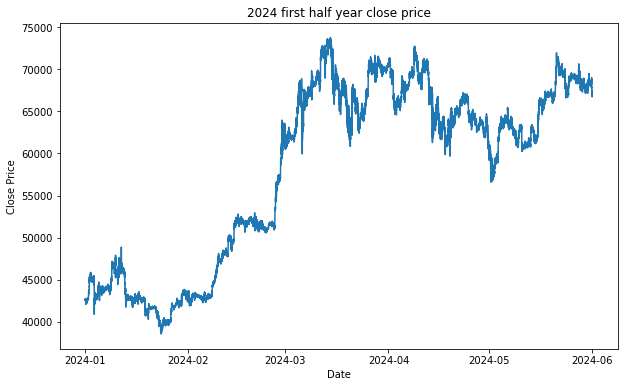

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(data.dataframe['e_date'], data.dataframe['close'])
plt.title('2024 first half year close price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

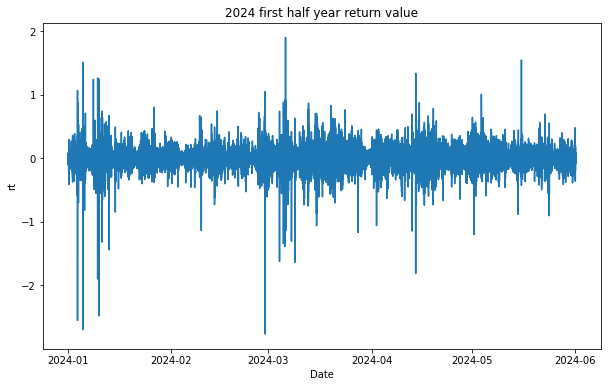

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(data.dataframe['e_date'], data.dataframe['return_close'])
plt.title('2024 first half year return value')
plt.xlabel('Date')
plt.ylabel('rt')
plt.show()